In [2]:
%matplotlib inline
import random
import time
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams
import os
import json

In [3]:
USING_COLAB = False

In [4]:
WIDTH_DIVISIONS = 1
HEIGHT_DIVISIONS = 1
IMG_WIDTH = 128
IMG_HEIGHT = 64

In [5]:
PATH_PREFIX = ''
if USING_COLAB:
    PATH_PREFIX = 'drive/ANPR/'

In [6]:
MODEL_PATH = PATH_PREFIX + 'data/boundingbox'
SAMPLES_PATHS = [PATH_PREFIX + 'data/boundingbox/j__artificial']

In [7]:
EPOCH = 20

In [8]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [9]:
def LoadImage(fname):
    return io.imread(fname)[:,:] / 255.

In [10]:
def ConvertToGrid(xa, ya, xb, yb):
    img_width = IMG_WIDTH
    img_height = IMG_HEIGHT
    width_divisions = WIDTH_DIVISIONS
    height_divisions = HEIGHT_DIVISIONS
    cell_width = img_width / width_divisions
    cell_height = img_height / height_divisions
    centerx = xa + (xb - xa) / 2
    centery = ya + (yb - ya) / 2
    width = xb - xa
    height = yb - ya
    label = np.array([])
    for i in range(0,height_divisions):
        for j in range(0,width_divisions):
            left = j * cell_width
            top = i * cell_height
            right = left + cell_width
            bottom = top + cell_height
            if centerx >= left and centerx < right and centery >= top and centery < bottom:
                grid_cell = np.array([1, (centerx - left) / cell_width, (centery - top) / 
                            cell_height, width / cell_width, height / cell_height])
            else:
                grid_cell = np.array([0,0,0,0,0])
            label = np.concatenate([label, grid_cell])
    return label

In [11]:
def LoadAnnotation(fname):
    with open(fname) as data_file:    
        data = json.load(data_file)

    left = data["objects"][0]["points"]["exterior"][0][0]
    top = data["objects"][0]["points"]["exterior"][0][1]
    right = data["objects"][0]["points"]["exterior"][2][0]
    bottom = data["objects"][0]["points"]["exterior"][2][1]
    return ConvertToGrid(left,top,right,bottom)

In [12]:
def ReadDirFiles(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".json")
        paths.append((img_name, ann_name))
    return paths

In [13]:
def ReadPaths(paths):
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

In [14]:
def get_tags(fname):
    with open(fname) as data_file:
        data = json.load(data_file)
    tags = data["tags"]
    return tags

In [15]:

def train_test_split(paths, train_percentage=.98):
    train_paths = []
    test_paths = []
    for path in paths:
        img_path, ann_path = path
        if random.random() < train_percentage:
            train_paths.append(path)
        else:
            test_paths.append(path)
    return train_paths, test_paths

In [16]:
all_paths = ReadPaths(SAMPLES_PATHS)
tr_paths, te_paths = train_test_split(all_paths)

print(len(tr_paths))
print(len(te_paths))


9790
210


In [17]:
def LoadData(paths):
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation(ann_path))
    
    return np.array(xs), np.array(ys)

In [18]:
X_train, Y_train = LoadData(tr_paths)
X_test, Y_test = LoadData(te_paths)

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)

check shapes:
X_train -  (9790, 64, 128)
Y_train -  (9790, 5)
X_test -  (210, 64, 128)
Y_test -  (210, 5)


In [19]:
def ExtractPredictions(predictions):
    result = np.array([])
    firstTime = True
    for prediction in predictions:
        sol = [0,0,0,0]
        left = 0
        top = 0
        for i in range(0, WIDTH_DIVISIONS * HEIGHT_DIVISIONS): 
            start_pos = i * 5
            if prediction[start_pos] > 0.4:
                center_x = prediction[start_pos+1]
                center_y = prediction[start_pos+2]
                width = prediction[start_pos+3]
                height = prediction[start_pos+4]
                center_x *= IMG_WIDTH / WIDTH_DIVISIONS
                center_y *= IMG_HEIGHT / HEIGHT_DIVISIONS
                width *= IMG_WIDTH / WIDTH_DIVISIONS
                height *= IMG_HEIGHT / HEIGHT_DIVISIONS
                center_x += left
                center_y += top
                xa = center_x - width / 2
                ya = center_y - height / 2
                xb = center_x + width / 2
                yb = center_y + height / 2
                sol = np.array([xa, ya, xb, yb])
                break
            left = left + IMG_WIDTH / WIDTH_DIVISIONS
            if left == IMG_WIDTH:
                left = 0
                top = top + IMG_HEIGHT / HEIGHT_DIVISIONS
        if firstTime:
            firstTime = False
            result = np.array([sol])
        else:
            result = np.append(result, [sol], axis=0)
    return result

<Figure size 1008x576 with 0 Axes>

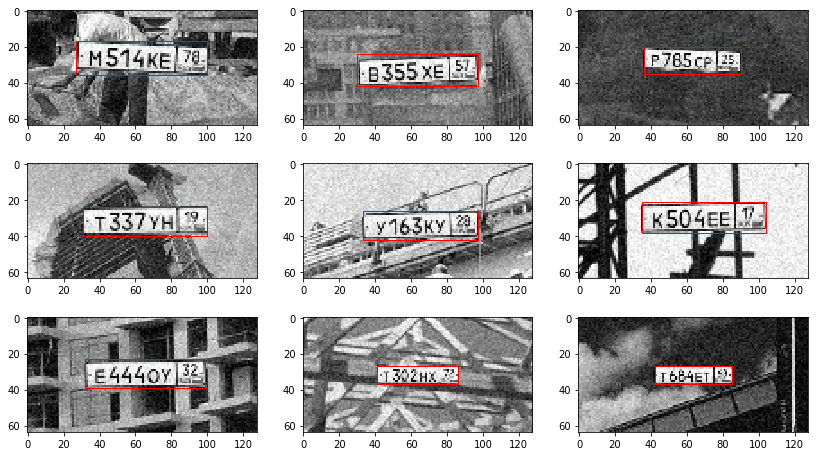

In [20]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]                   
plot_images(X_train[xs], ExtractPredictions(Y_train[xs]))

In [21]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

In [22]:
def mse(expected, predicted):
    for i in range(0,WIDTH_DIVISIONS * HEIGHT_DIVISIONS):
        start_pos = i * 5
        end_pos = start_pos + 5
        if expected[start_pos] == 0:
            for j in range(start_pos, end_pos):
                predicted[j] = 0
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)
def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [23]:
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
LABEL_COUNT = Y_train.shape[1]
# Create placeholders for image data and expected point positions

class Model(object):
    xxx = 0
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 64, 128, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 1, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [2, 2, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [2, 2, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
    W_fc1 = weight_variable("w4", [8*16*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)   
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)  
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output
    
    return model

In [24]:
X2_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
Y2_train = Y_train # / (64.0, 32.0, 64.0, 32.0) - 1.0

X2_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
Y2_test = Y_test # / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [25]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.AdamOptimizer().minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    # saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    # if False:
    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
        
    session.close()

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0, Score: 393.345337, Epoch per minute: 0.000000


Epoch: 1, Score: 0.013855, Epoch per minute: 0.316071


Epoch: 2, Score: 0.010473, Epoch per minute: 0.323034


Epoch: 3, Score: 0.005564, Epoch per minute: 0.333547


Epoch: 4, Score: 0.004282, Epoch per minute: 0.354590


Epoch: 5, Score: 0.003754, Epoch per minute: 0.367655


Epoch: 6, Score: 0.002630, Epoch per minute: 0.378036


Epoch: 7, Score: 0.002559, Epoch per minute: 0.384003


Epoch: 8, Score: 0.001972, Epoch per minute: 0.389108


Epoch: 9, Score: 0.001493, Epoch per minute: 0.390398


Epoch: 10, Score: 0.001405, Epoch per minute: 0.393053


Epoch: 11, Score: 0.001256, Epoch per minute: 0.389904


Epoch: 12, Score: 0.001070, Epoch per minute: 0.392525


Epoch: 13, Score: 0.000981, Epoch per minute: 0.396707


Epoch: 14, Score: 0.000830, Epoch per minute: 0.399420


Epoch: 15, Score: 0.000653, Epoch per minute: 0.402980


Epoch: 16, Score: 0.000572, Epoch per minute: 0.403902


Epoch: 17, Score: 0.000616, Epoch per minute: 0.409872


Epoch: 18, Score: 0.000523, Epoch per minute: 0.415055


Epoch: 19, Score: 0.000487, Epoch per minute: 0.419783


Epoch: 20, Score: 0.000410, Epoch per minute: 0.423083
Finished in 2836.325026 seconds.


/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from data/boundingbox/model


<Figure size 1008x576 with 0 Axes>

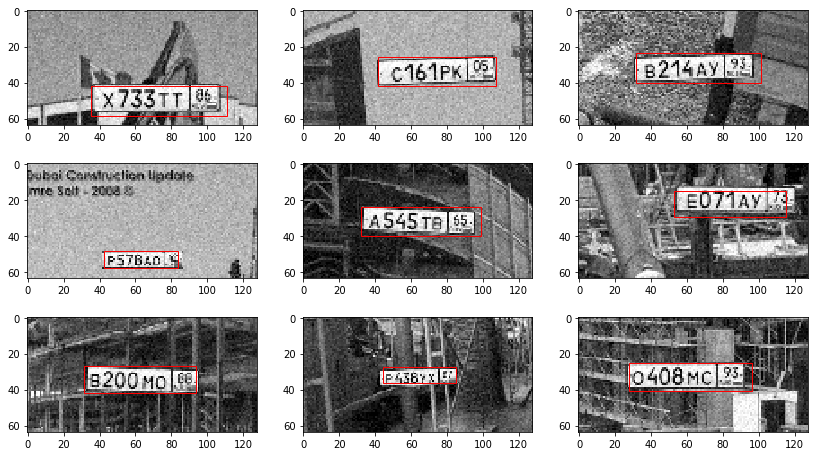

In [26]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    ids = [random.randint(0, X2_test.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_test[ids]})
    plot_images(X_test[ids], ExtractPredictions(predictions))
    session.close()

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from data/boundingbox/model


<Figure size 1008x576 with 0 Axes>

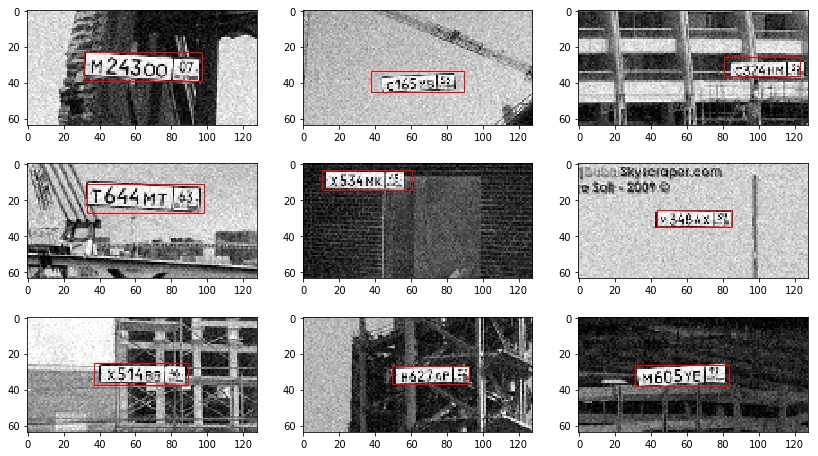

In [27]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_train[ids]})
    plot_images(X_train[ids], ExtractPredictions(predictions))

    session.close()

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from data/boundingbox/model


1.0042156
0.3911900520324707


<Figure size 1008x576 with 0 Axes>

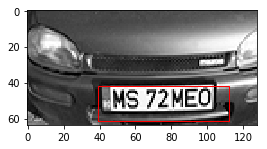

In [45]:
start_time = time.time()
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    image = np.array([LoadImage("poza4.jpg")])
    imagePredict = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
    
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: imagePredict})
    print(predictions[0][0])
    print(time.time() - start_time)
    plot_images(image, ExtractPredictions(predictions))

    session.close()